# Clustering using numerical and categorical data : K-Prototypes

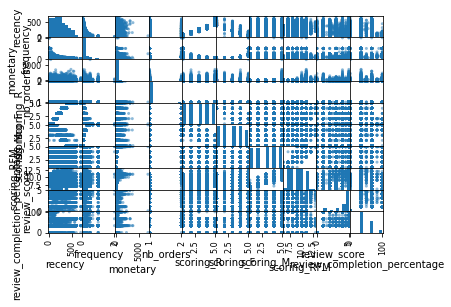

In [13]:
import pandas as pd
import numpy as np
import os
import sys
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split

rms = pd.read_csv("./../../../output/rms.csv")
y = rms["review_score"]

X_train, X_test, y_train, y_test = train_test_split(
    rms, y, test_size=0.2, random_state=42, stratify=y
)
rms = X_test

pd.plotting.scatter_matrix(rms);

## Variables transformation from numerical to categorical

And what if we consider the frequency as a category ?

* It can be interesting to consider single order customers to the others ones.
* Also, we could consider customers who contribute reviews (title, message) from the one who don't.
* As monetary is really skewed, we may introduce bins.

Let's try this and see if we can have a better clustering after that !

In [14]:
rms

recency  frequency  monetary  nb_orders  scoring_R  scoring_F  \
4346     425.0   0.066667    116.36        1.0          5          1   
37624    117.0   0.200000    115.48        1.0          2          4   
34075    143.0   0.166667    594.42        1.0          2          4   
89326    322.0   0.083333     83.94        1.0          4          2   
79142    278.0   0.100000     52.78        1.0          4          2   
...        ...        ...       ...        ...        ...        ...   
18638    139.0   0.166667     72.28        1.0          2          4   
50936     42.0   0.500000    122.97        1.0          1          5   
38477    402.0   0.071429    135.12        1.0          5          1   
90762     42.0   0.500000    219.44        1.0          1          5   
44912    273.0   0.100000     84.49        1.0          4          2   

       scoring_M  scoring_RFM   segment_RFM  review_score  \
4346           3            9  Bons clients           5.0   
37624          3            9  Bons clients           5.0   
34075          5           11  Bons clients           5.0   
89326          2            8  Bons clients           5.0   
79142          1            7  Bons clients           5.0   
...          ...          ...           ...           ...   
18638          2            8  Bons clients           4.0   
50936          3            9  Bons clients           4.0   
38477          4           10  Bons clients           5.0   
90762          5           11  Bons clients           0.0   
44912          2            8  Bons clients           5.0   

       review_completion_percentage   review_behavior  
4346                      33.333333  Best Contributor  
37624                    100.000000  Best Contributor  
34075                     66.666667  Best Contributor  
89326                     33.333333  Best Contributor  
79142                     33.333333  Best Contributor  
...                             ...               ...  
18638                     33.333333  Best Contributor  
50936                     33.333333  Best Contributor  
38477                     66.666667  Best Contributor  
90762                      0.000000            Silent  
44912                     33.333333  Best Contributor  

[18622 rows x 12 columns]

Let's plot the distribution of monetary :

In [15]:
rms.monetary.describe()

count    18622.000000
mean       162.613064
std        207.110202
min         13.290000
25%         63.652500
50%        108.200000
75%        182.657500
max       6922.210000
Name: monetary, dtype: float64

## Using K-Prototype clustering method

We have to evaluate the right number of clusters even if we are confident it's around **5** as stated by our previous experiments.

In [16]:
# Prepare variables for transformation and remove useless ones
transformed_customers = rms.copy()
transformed_customers = transformed_customers.drop(
    columns=["review_completion_percentage", "nb_orders"]
)
transformed_customers.loc[
    transformed_customers.review_score == 0, "review_score"
] = 1e-5

transformed_customers.head()

recency  frequency  monetary  scoring_R  scoring_F  scoring_M  \
4346     425.0   0.066667    116.36          5          1          3   
37624    117.0   0.200000    115.48          2          4          3   
34075    143.0   0.166667    594.42          2          4          5   
89326    322.0   0.083333     83.94          4          2          2   
79142    278.0   0.100000     52.78          4          2          1   

       scoring_RFM   segment_RFM  review_score   review_behavior  
4346             9  Bons clients           5.0  Best Contributor  
37624            9  Bons clients           5.0  Best Contributor  
34075           11  Bons clients           5.0  Best Contributor  
89326            8  Bons clients           5.0  Best Contributor  
79142            7  Bons clients           5.0  Best Contributor

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Pre-processing
for feature in transformed_customers.select_dtypes(
    exclude=["object", "category"]
).columns:
    pipeline = make_pipeline(StandardScaler(), PowerTransformer())

    transformed_customers[feature] = pipeline.fit_transform(
        np.array(transformed_customers[feature]).reshape(-1, 1)
    )

transformed_customers.head()

recency  frequency  monetary  scoring_R  scoring_F  scoring_M  \
4346   1.187065  -1.129138  0.053124   1.415281  -1.405433  -0.017084   
37624 -0.785054   0.706421  0.041074  -0.710300   0.788500  -0.017084   
34075 -0.575566   0.410714  1.917256  -0.710300   0.788500   1.412229   
89326  0.636911  -0.795069 -0.446109   0.704636  -0.656079  -0.722941   
79142  0.376436  -0.494076 -1.040918   0.704636  -0.656079  -1.424166   

       scoring_RFM   segment_RFM  review_score   review_behavior  
4346      0.052940  Bons clients      0.813111  Best Contributor  
37624     0.052940  Bons clients      0.813111  Best Contributor  
34075     1.391212  Bons clients      0.813111  Best Contributor  
89326    -0.631143  Bons clients      0.813111  Best Contributor  
79142    -1.323735  Bons clients      0.813111  Best Contributor

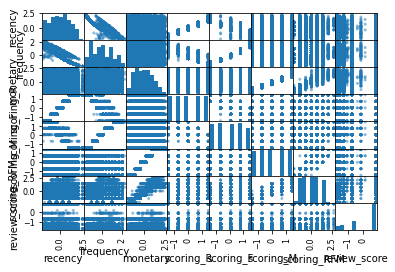

In [23]:
pd.plotting.scatter_matrix(pd.DataFrame(transformed_customers));

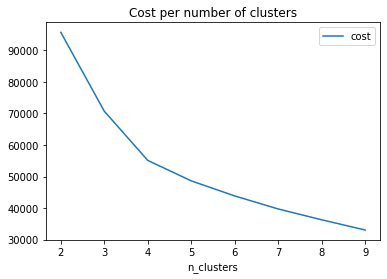

In [18]:
from kmodes.kprototypes import KPrototypes

costs = []

for n_clusters in list(range(2, 10)):
    k_prototypes = KPrototypes(n_clusters=n_clusters, random_state=42, n_jobs=-1)
    k_prototypes.fit_predict(transformed_customers, categorical=[7, 9])
    costs.append({"n_clusters": n_clusters, "cost": k_prototypes.cost_})

pd.DataFrame(costs).plot(title="Cost per number of clusters", x="n_clusters", y="cost");

1    5562
0    4821
3    4373
2    3866
Name: cluster, dtype: int64


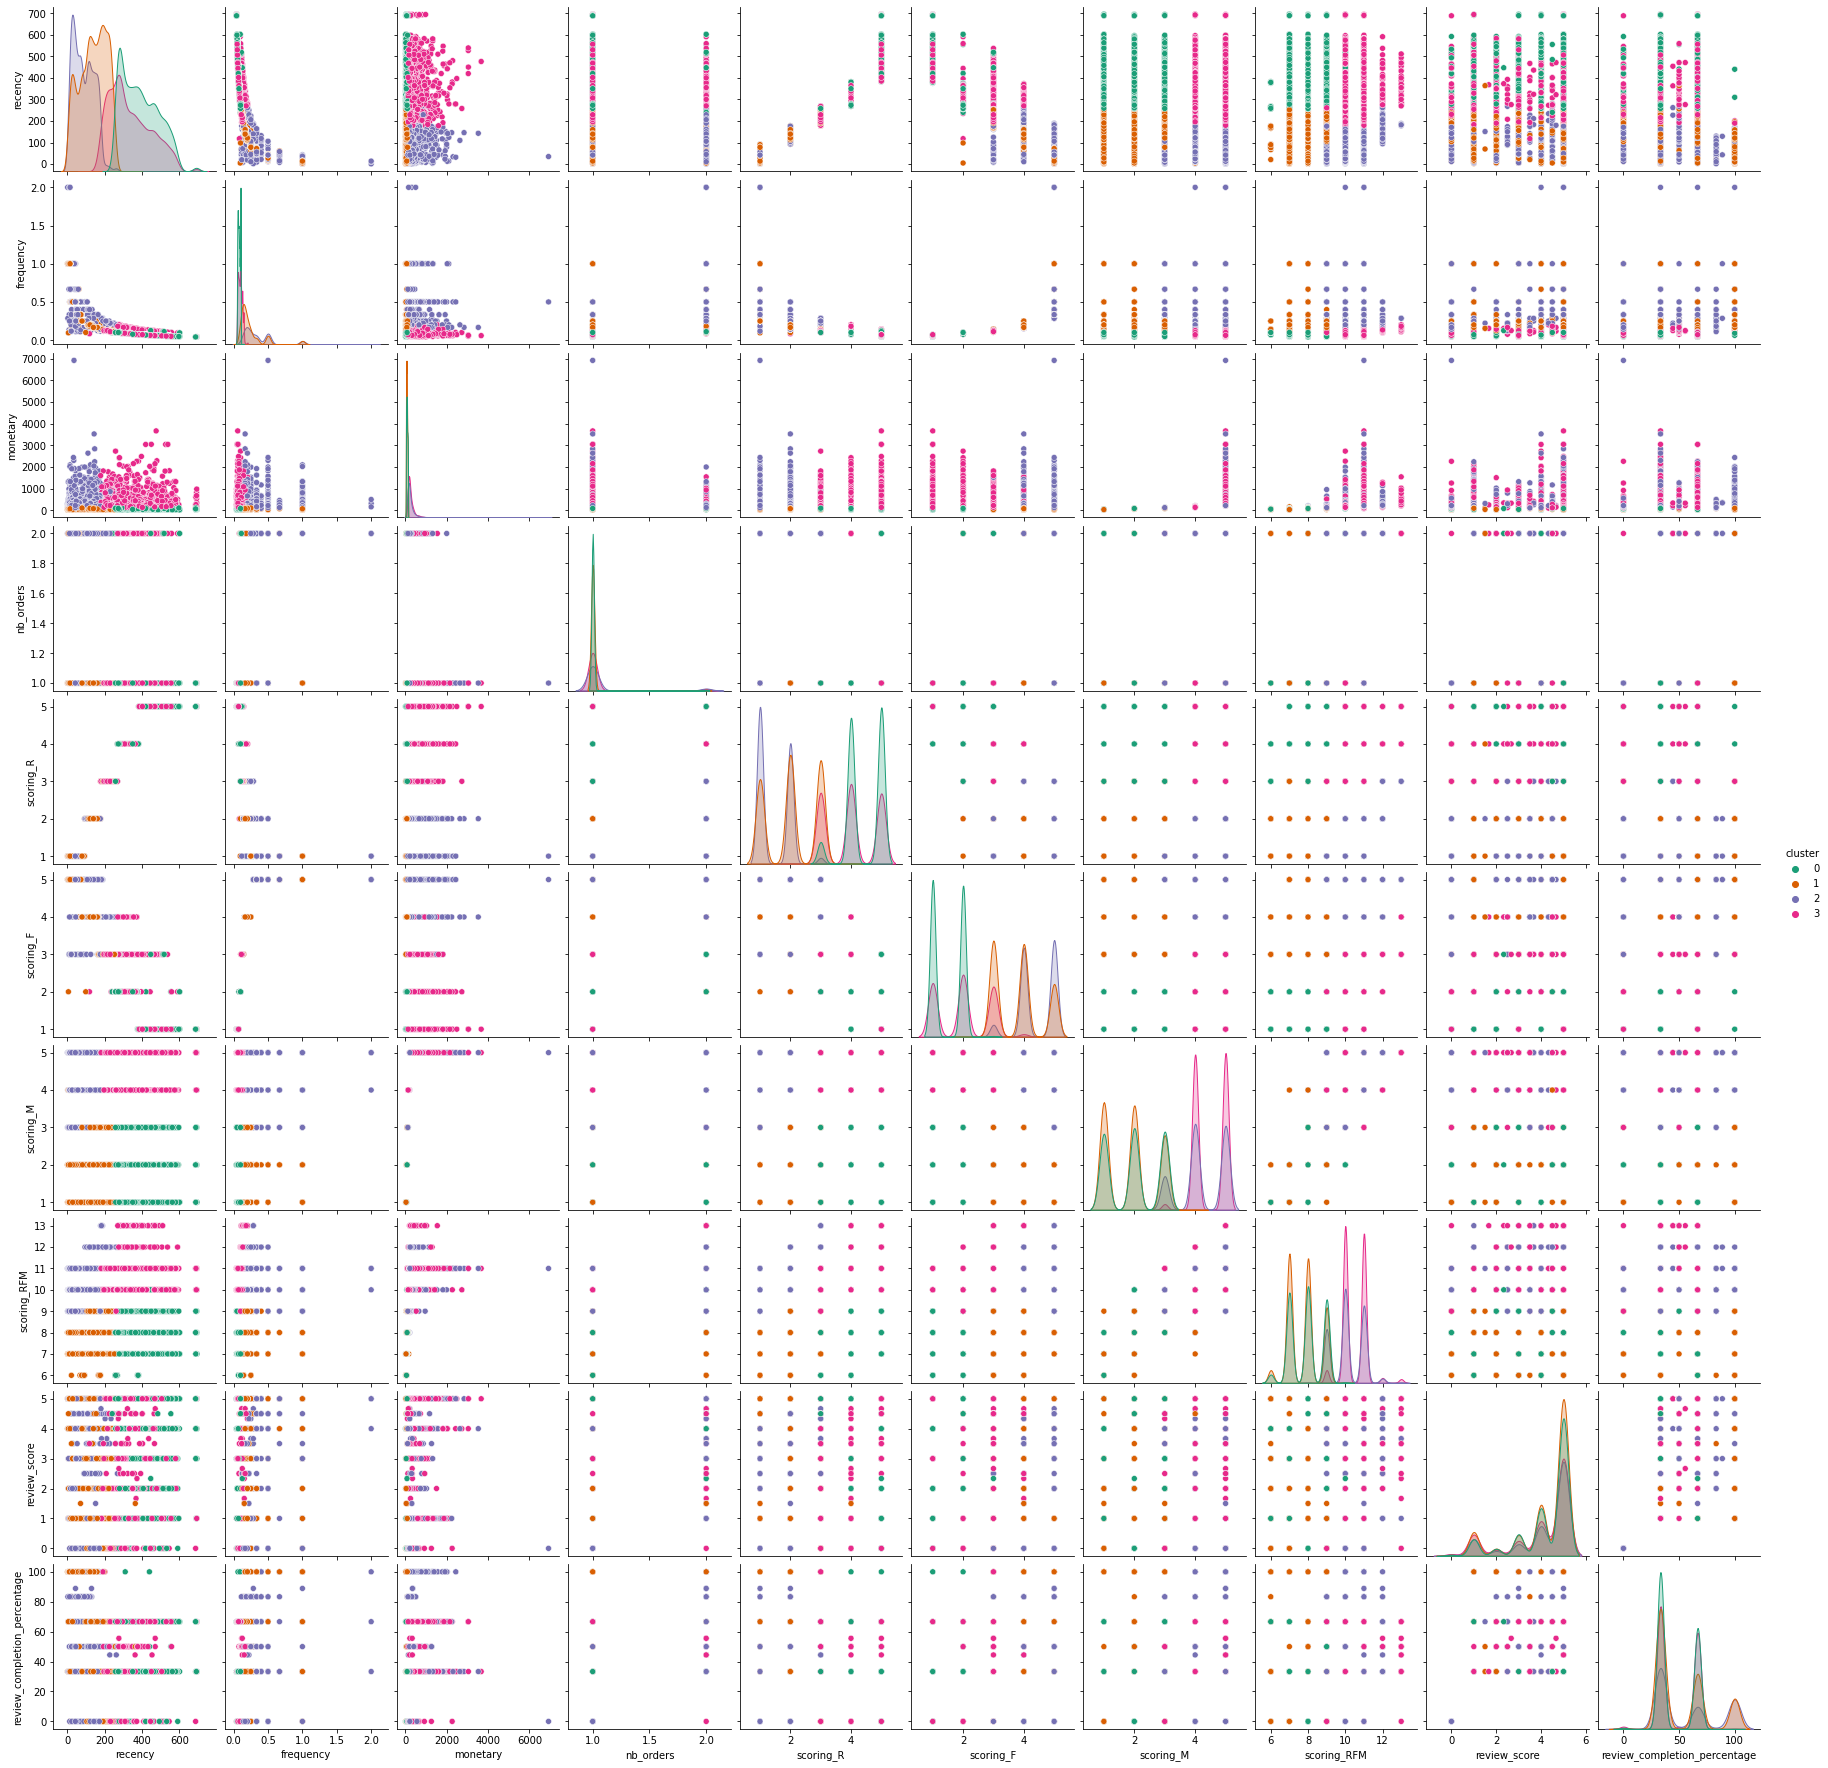

In [19]:
import seaborn as sns
from sklearn import metrics

k_prototypes = KPrototypes(n_clusters=4, random_state=42, n_jobs=-1)

rms["cluster"] = k_prototypes.fit_predict(transformed_customers, categorical=[7, 9])
rms["cluster"] = rms.cluster.astype("category")

print(rms["cluster"].value_counts())

sns.pairplot(rms, hue="cluster", palette="Dark2", diag_kind="kde");

## Clustering visualisation

In [20]:
from sklearn.manifold import TSNE
import plotly.express as px

# Create dummies for categorical variables
df = pd.get_dummies(
    pd.DataFrame(transformed_customers),
    prefix="",
    prefix_sep="",
    columns=["review_behavior", "segment_RFM"],
)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df, rms["cluster"]))

tsne = TSNE(n_components=2, learning_rate="auto", init="random", n_jobs=-1)

projected_customers = tsne.fit_transform(df)

fig = px.scatter(
    projected_customers,
    x=0,
    y=1,
    color=rms.cluster,
    labels={"color": "cluster"},
    opacity=0.8,
)
fig.show()

Silhouette Coefficient: 0.300


In [21]:
tsne = TSNE(n_components=3, learning_rate="auto", init="random", n_jobs=-1)

projected_customers = tsne.fit_transform(df)

fig = px.scatter_3d(
    projected_customers,
    x=0,
    y=1,
    z=2,
    color=rms.cluster,
    labels={"color": "cluster"},
    opacity=0.8,
)
fig.show()

In [22]:
print("END")

END
